In [183]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import math
from scipy import stats
import pandas as pd
import matplotlib as mpl
from sklearn.linear_model import LinearRegression

In [5]:
n = 2**10
t = 500
p = 0.0217
omega = 1
size = 1
k = 1

M = 500
d = 1.12

In [3]:
def buy_sell_hold(p):
    assert p <= 0.5, "p should be smaller than 0.5"
    p_b = p # buy/sell
    p_s = p
    p_h = 1 - 2*p # hold
    dice = rnd.uniform(0, 1)
    # if the dice rolls below p, roll a 50/50 dice to decide buy or sell
    if dice <= 2*p:
        if rnd.choice([0, 1]) == 0:
            psi = 1
        else:
            psi = -1
    else:
        psi = 0
    return psi

In [201]:
class Agent:
    def __init__(self, size) -> None:
        self.size = size

class Model:
    def __init__(self, p: float, n: int, size: int, k: int, omega: int) -> None:
        self.n = n
        self.p = p
        self.agents = [Agent(size) for i in range(n)]
        self.daily_return = []
        self.trading_volume = 0
        self.k = k
        self.omega = omega
        self.daily_returns = []
        self.count = 0

        self.daily_trading_volumes = []

        
    def distribute_opinion_groups(self) -> None:
        
        # number of opinion groups
        if sum(self.daily_return) != 0:
            c = (self.n // abs(sum(self.daily_return))) ** self.omega
        else:
            c = self.n
            
        
        opinion_groups = [[] for i in range(round(c))]
        opinion_agents = self.agents.copy()

        # distribute agents evenly
        for opinion_group in opinion_groups:
            for i in range(round(self.n / c)):
                if len(opinion_agents) > 0:
                    i = rnd.choice([i for i in range(len(opinion_agents))])

                    opinion_group.append(opinion_agents[i])
                    del opinion_agents[i]
                else:
                    break
                
        return opinion_groups

    def step(self):
        self.count += 1
        opinion_groups = self.distribute_opinion_groups()
        self.daily_return = []
        self.trading_volume = 0

        for opinion_group in opinion_groups:
            psi = buy_sell_hold(self.p)
            self.daily_return.append(psi * len(opinion_group))
            self.trading_volume += abs(psi * len(opinion_group))
    
        self.daily_returns.append(sum(self.daily_return) * k)
        self.daily_trading_volumes.append(self.trading_volume)

        return self.count

In [ ]:
# model w noise
class Model:
    def __init__(self, p: float, n: int, size: int, k: int, omega: int, b: int) -> None:
        self.n = n
        self.p = p
        self.agents = [Agent(size) for i in range(n)]
        self.daily_return = []
        self.trading_volume = 0
        self.k = k
        self.omega = omega
        self.daily_returns = []
        self.count = 0
        self.b = b

        self.daily_trading_volumes = []

        
    def distribute_opinion_groups(self) -> None:
        if self.b == 0:
        
            # number of opinion groups
            if sum(self.daily_return) != 0:
                c = (self.n // abs(sum(self.daily_return))) ** self.omega
            else:
                c = self.n
            
        
            opinion_groups = [[] for i in range(round(c))]
            opinion_agents = self.agents.copy()

            # distribute agents evenly
            for opinion_group in opinion_groups:
                for i in range(round(self.n / c)):
                    if len(opinion_agents) > 0:
                        i = rnd.choice([i for i in range(len(opinion_agents))])

                        opinion_group.append(opinion_agents[i])
                        del opinion_agents[i]
                    else:
                        break

        else:
            if sum(self.daily_return) != 0:
                mean = 0
            else:
                mean = self.n // abs(sum(self.daily_return))
            
            c = np.random.normal(loc = mean, scale = mean * self.b)

            opinion_groups = [[] for i in range(round(c))]
            opinion_agents = self.agents.copy()

            # distribute agents evenly
            for opinion_group in opinion_groups:
                for i in range(round(self.n / c)):
                    if len(opinion_agents) > 0:
                        i = rnd.choice([i for i in range(len(opinion_agents))])

                        opinion_group.append(opinion_agents[i])
                        del opinion_agents[i]
                    else:
                        break            
                
        return opinion_groups

    def step(self):
        self.count += 1
        opinion_groups = self.distribute_opinion_groups()
        self.daily_return = []
        self.trading_volume = 0

        for opinion_group in opinion_groups:
            psi = buy_sell_hold(self.p)
            self.daily_return.append(psi * len(opinion_group))
            self.trading_volume += abs(psi * len(opinion_group))
    
        self.daily_returns.append(sum(self.daily_return) * k)
        self.daily_trading_volumes.append(self.trading_volume)

        return self.count

In [9]:
# ABM

model_test = Model(p, n, size, k, omega)
for i in range(t):
    model_test.step()


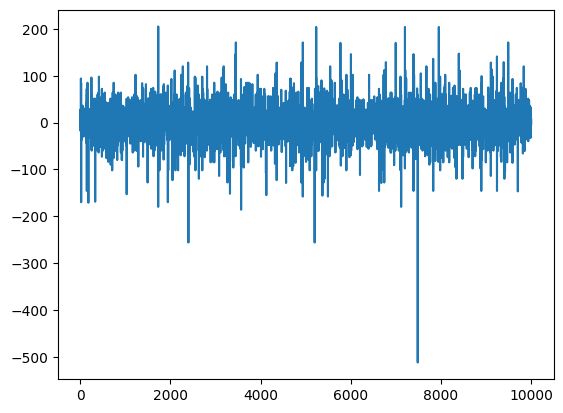

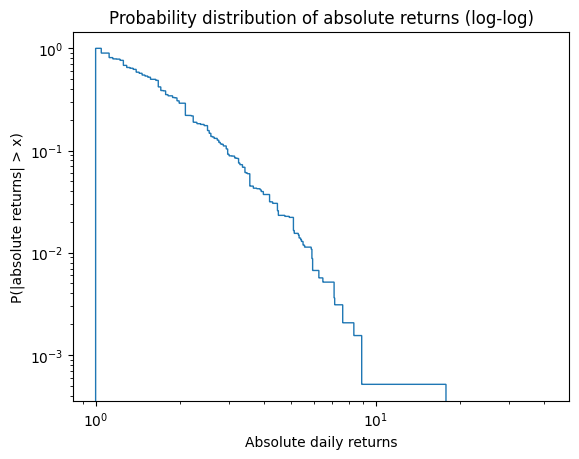

In [11]:
# logarithmic bins
bin=np.logspace(start=0, stop=np.log(5), num=t)

# normalised returns
returns = [(abs(day) - np.mean(model_test.daily_returns)) / np.std(model_test.daily_returns) for day in model_test.daily_returns]

plt.plot(model_test.daily_returns)
plt.show()

plt.figure(1)
plt.hist(returns, bin, cumulative=-1, density=True, log=True, histtype='step')
plt.title("Probability distribution of absolute returns (log-log)")
plt.xlabel("Absolute daily returns")
plt.ylabel("P(|absolute returns| > x)")
plt.gca().set_xscale("log")
plt.show()


In [227]:
class Stochastic_Model:
    def __init__(self, n: int, p: float, init: int, time_horizon: bool, M, d):
        self.returns = [init]
        self.n = n
        self.p = p
        self.time_horizon = time_horizon
        self.M = M
        self.d = d

    def time_horizons(self):
        time_horizons = []
        alpha = []

        # distribution of agents in different time horizons
        # agents are allocated to each time horizon (with exponential decay as we go back in time), until we reach the limit M
        # or until we reach the beginning of the simulation (if current timestep t < M)
        for i in range(1, self.M + 1):
            if len(self.returns) == 1:
                value = (i ** -self.d) * abs(self.returns[-1])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            elif i >= len(self.returns):
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[0])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            else:
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[-1-i])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

        return sum(time_horizons) * (sum(alpha) ** -1)

    def step(self):

        # Agents only factor in the returns at the previous timestep
        if self.time_horizon == False:
            variance  = 2 * p * n * abs(self.returns[-1])
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)
        
        # Agents look back M timesteps
        if self.time_horizon == True:
            horizons = self.time_horizons()
            variance  = 2 * p * n * horizons
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)  

In [8]:
# Stochastic simulation

stochastic = Stochastic_Model(n, p, 10, time_horizon=False, M=10, d=1.12)
stochastic_horizons = Stochastic_Model(n, p, 10, time_horizon=True, M=10, d=1.12)

for i in range(t):
    stochastic.step()
    stochastic_horizons.step()

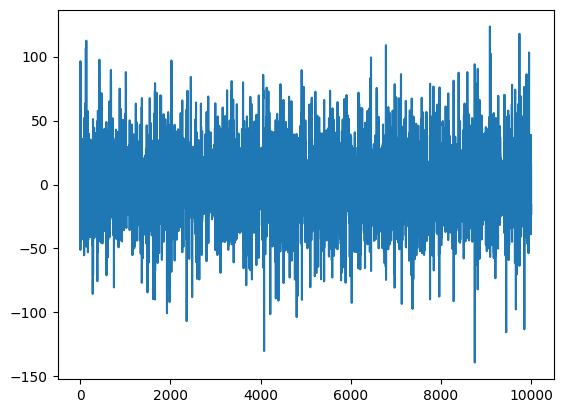

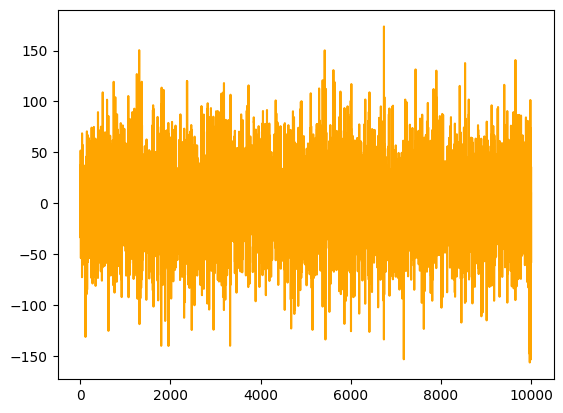

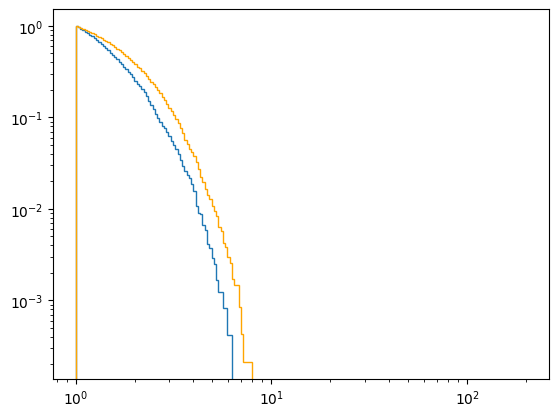

In [10]:
plt.plot(range(t + 1), stochastic.returns)
plt.show()

plt.plot(range(t+1), stochastic_horizons.returns, color='orange')
plt.show()

abs_returns = [(abs(i) - np.mean(stochastic.returns)) / (np.std(stochastic.returns)) for i in stochastic.returns]
abs_returns_horizons = [(abs(i) - np.mean(abs_returns)) / (np.std(stochastic.returns)) for i in stochastic_horizons.returns]
bin=np.logspace(start=0, stop=np.log(10), num=200)

plt.hist(abs_returns, bins=bin, cumulative=-1, density=True, log=True, histtype='step')
plt.hist(abs_returns_horizons, bin, cumulative=-1, density=True, log=True, histtype='step', color = 'orange')
plt.gca().set_xscale("log")
plt.show()

In [65]:
# note the return transformation is done by taking log differences
real_stock_return_data = pd.read_csv('data/df_daily_returns_clean.csv').drop(columns=['Date']).values[1:,].flatten()

In [20]:
def Hills_estimator(input:list)->float:
    # Hills estimator for fat tails
    # Reference: code for hills estimator for fitting of fat tails of distributions from : https://www.financialriskforecasting.com/code/MATLABPython9.html
    # free to use under GNU GPL license https://www.gnu.org/licenses/#GPL
    input
    input_sort = np.sort(input)   # sort the returns
    CT = 100   # set the threshold
    iota = 1/(np.mean(np.log(input_sort[0:CT]/input_sort[CT]))) # get the tail index
    print(iota)

Note: Hills estimator currently bugged so it is commented out in the code below

In [66]:
# Reference: code for hills estimator for fitting of fat tails of distributions from : https://www.financialriskforecasting.com/code/MATLABPython9.html
# free to use under GNU GPL license https://www.gnu.org/licenses/#GPL

y_1_stoch = np.array(abs_returns_horizons)
y_2_stoch = np.array(abs_returns)
y_3_ABM = np.array(returns)

return_datasets = [y_1_stoch, y_2_stoch, y_3_ABM, real_stock_return_data]
# for return_dataset in return_datasets:
#     Hills_estimator(return_datasets)

In [23]:
# code for kolmogorov-smirnov test for similarity of distributions: reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
# assumed samples are independent


In [76]:
# code for kolmogorov-smirnov test for similarity of distributions: reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
# assumed samples are independent

# making a matrix in which ks test results will be visualised

array_for_ks_test_results = np.zeros((4,4))
for i in range(len(return_datasets)):
    for j in range(len(return_datasets)):
        # returning the 1st element of ks test result as this is the p-value of the ks test
        # print(stats.kstest(return_datasets[i], return_datasets[j])[1])
            array_for_ks_test_results[i,j] = stats.kstest(return_datasets[i], return_datasets[j])[1]

In [79]:
df_of_kstest_results = pd.DataFrame(array_for_ks_test_results)
df_of_kstest_results

,0,1,2,3
0,1.000000e+00,9.216294e-240,0.000000e+00,0.0
1,9.216294e-240,1.000000e+00,9.295303e-231,0.0
2,0.000000e+00,9.295303e-231,1.000000e+00,0.0
3,0.000000e+00,0.000000e+00,0.000000e+00,1.0


In [96]:
color_matrix

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

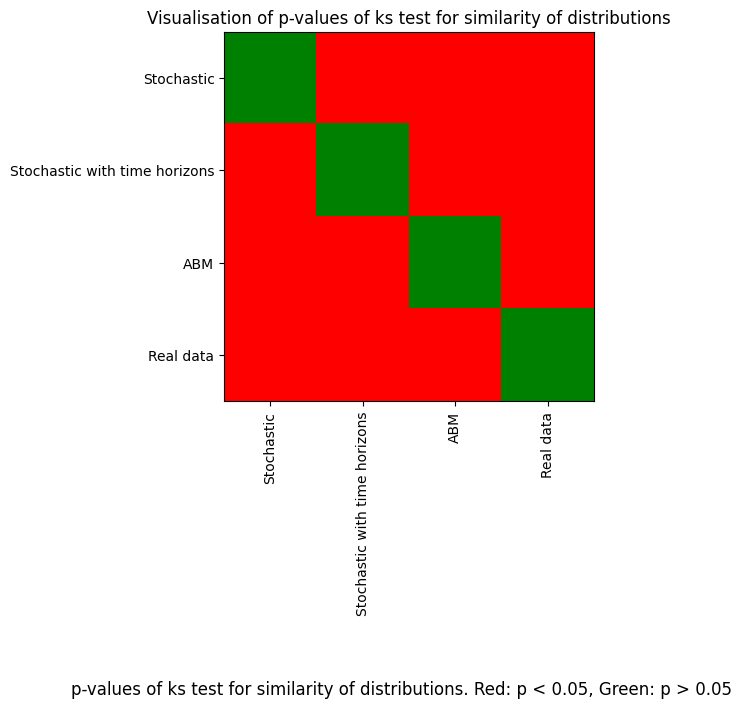

In [95]:
color_matrix = np.where(array_for_ks_test_results < 0.05, 0,1)
cmap = (mpl.colors.ListedColormap(['red', 'green']))
plt.imshow(color_matrix, cmap=cmap, vmin=0, vmax=1)
plt.xticks([0,1,2,3], ['Stochastic', 'Stochastic with time horizons', 'ABM', 'Real data'], rotation = 90)
plt.yticks([0,1,2,3], ['Stochastic', 'Stochastic with time horizons', 'ABM', 'Real data'])
plt.title("Visualisation of p-values of ks test for similarity of distributions")
plt.figtext(0.5, -0.5, "p-values of ks test for similarity of distributions. Red: p < 0.05, Green: p > 0.05", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

In [164]:
def regression(data_x, data_y, beta, learning_rate, iterations):
    rmse = np.mean([((beta * data_x[i]) - data_y[i])**2 for i in range(len(data_y))])
    diff_beta = beta

    while diff_beta > 10:
        # find differentials of the parametres
        #diff_alpha = 2 * np.mean([((alpha + beta * data_x[i]) - data_y[i]) for i in range(len(data_y))])
        diff_beta = 2 * np.mean([(((data_x[i] * beta) - data_y[i]) * data_x[i]) for i in range(len(data_y))])
        print(diff_beta)

        #alpha_new = alpha + (learning_rate * diff_alpha)
        beta = beta - learning_rate * diff_beta

        rmse_zero_new = np.mean([((beta * data_x[i]) - data_y[i])**2 for i in range(len(data_y))])

        # keep new parametres if they lead to smaller rmse
        #if rmse_zero_new < rmse:
            #alpha = alpha_new
        #beta = beta_new
        rmse = rmse_zero_new

    return beta, rmse

In [26]:
def r_squared(data, alpha, beta, x_range):
    """
    Goodness of fit test for regression
    """
    ss_res = []
    ss_total = []
    mean = np.mean(data)

    for i in range(len(x_range)):
        prediction = alpha + beta * x_range[i]
        value = data[i]

        residual = (value - prediction) ** 2
        total = (value - mean) ** 2

        ss_res.append(residual)
        ss_total.append(total)

    return 1 - (sum(ss_res) / sum(ss_total))


In [ ]:
# k_test - think about ways to fit a power law
k_range = [i*0.1 for i in range(51)]
variances = []

for i in k_range:
    k = i
    k_test = Model(p, n, size, k, omega)
    for step in range(t):
        k_test.step()

    variance = np.std(k_test.daily_returns) ** 2
    variances.append(variance)

In [ ]:
variance_array = np.array(variances)
range_array = np.array(k_range).reshape((-1, 1))

regress = LinearRegression().fit(range_array, variance_array)

In [198]:
k_test = r_squared(variances, regress.intercept_, regress.coef_, k_range)
print(k_test)

[0.92647457]


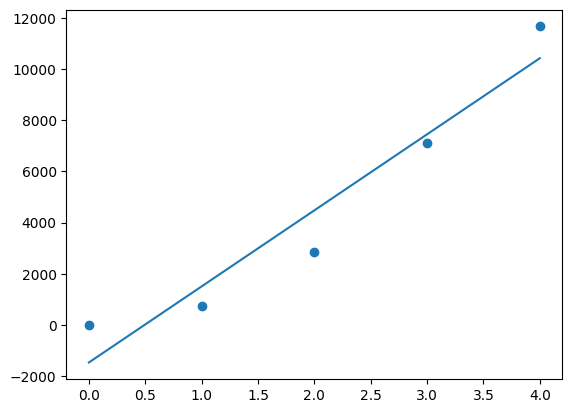

In [ ]:
plt.plot(k_range, [(regress.intercept_ + regress.coef_ * i) for i in k_range])
plt.scatter(k_range, variances)
plt.show()

In [202]:
# omega_test - think about ways to fit a power law
omega_range = [i*0.1 for i in range(1, 51)]
variances = []

for i in omega_range:
    omega = i
    omega_test = Model(p, n, size, k, omega)
    for step in range(t):
        omega_test.step()

    variance = np.std(omega_test.daily_returns) ** 2
    variances.append(variance)

omega_array = np.array(omega_range).reshape((-1, 1))
omega_variances = np.array(variances)

KeyboardInterrupt: 

In [203]:
# omega - calculate regression of power law exponent and variances
omega_r = LinearRegression().fit(omega_array, omega_variances)
omega_test = r_squared(variances, omega_r.intercept_, omega_r.coef_, omega_range)


NameError: name 'omega_array' is not defined

In [ ]:
plt.plot(omega_range, [(omega_r.intercept_ + omega_r.coef_ * i) for i in k_range])
plt.scatter(omega_range, variances)
plt.show()

In [222]:
# p_test - variances; mean number of zeros
p_range = [i*0.1 for i in range(1, 6)]
variances = []
zeros = []

for i in p_range:
    p = i
    p_test = Model(p, n, size, k, omega)
    for step in range(100):
        p_test.step()

    variance = np.std(p_test.daily_returns) ** 2
    variances.append(variance)

    for u in p_test.daily_returns:
        zero = []
        if -0.5 < u < 0.5:
            zero.append(1)
        
    zero_add = sum(zero) / len(p_test.daily_returns)
    zeros.append(zero_add)

    print(i)

p_array = np.array(p_range).reshape((-1, 1))
p_variances = np.array(variances)
p_zeros = np.array(zeros)

0.1
0.2
0.30000000000000004
0.4
0.5


In [223]:
p_zeros_r = LinearRegression().fit(p_array, p_zeros)
p_variances_r = LinearRegression().fit(p_array, p_variances)

p_test_zeros = r_squared(zeros, p_zeros_r.intercept_, p_zeros_r.coef_, p_range)
p_test_variances = r_squared(variances, p_variances_r.intercept_, p_variances_r.coef_, p_range)

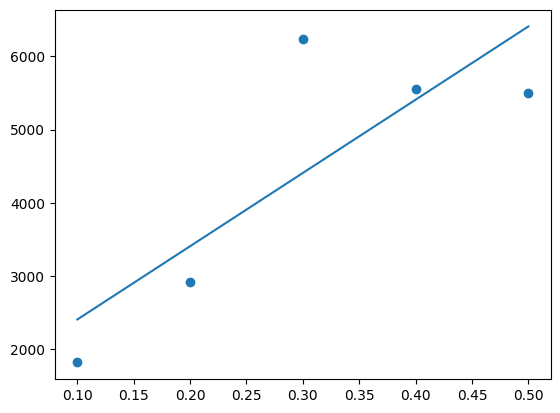

In [224]:
plt.plot(p_range, [(p_variances_r.intercept_ + p_variances_r.coef_ * i) for i in p_range])
plt.scatter(p_range, variances)
plt.show()

In [225]:
print("R^2 of variance fit =", p_test_variances)
print("R^2 of mean zero fit =", p_test_zeros)

R^2 of variance fit = [0.67659278]
R^2 of mean zero fit = [0.33333333]


In [237]:
# M
m_range = [i for i in range(1, 500)]
variances = []

for i in m_range:
    m_test = Stochastic_Model(n, p, 10, True, i, 1.12)
    for step in range(t):
        m_test.step()

    variance = np.std(m_test.returns) ** 2
    variances.append(variance)

m_array = np.array(m_range).reshape((-1, 1))
m_variances = np.array(variances)

KeyboardInterrupt: 

In [231]:
m_variances_r = LinearRegression().fit(m_array, m_variances)
m_test = r_squared(variances, m_variances_r.intercept_, m_variances_r.coef_, m_range)

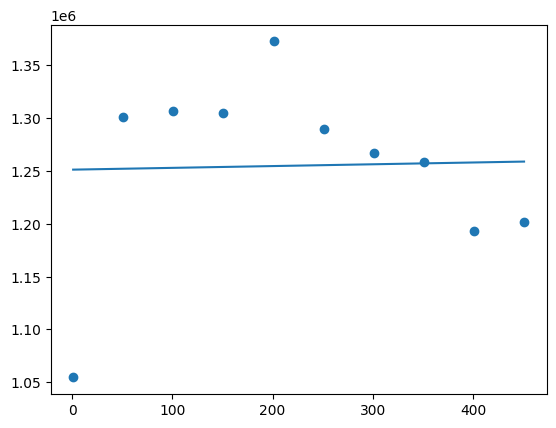

In [233]:
plt.plot(m_range, [(m_variances_r.intercept_ + m_variances_r.coef_ * i) for i in m_range])
plt.scatter(m_range, variances)
plt.show()

In [234]:
print("R^2 of variance fit =", m_test)


R^2 of variance fit = [0.00085579]


In [ ]:
# D
d_range = [i*0.1 for i in range(1, 21)]
variances = []

for i in d_range:
    d_test = Stochastic_Model(n, p, 10, True, 500, i)
    for step in range(t):
        d_test.step()

    variance = np.std(d_test.daily_returns) ** 2
    variances.append(variance)

d_array = np.array(d_range).reshape((-1, 1))
d_variances = np.array(variances)

In [ ]:
# Example of parameter generation
parameters = np.arange(0, 10, 1)
print("parameters to test:", parameters)


def gridsearch(real, abm_or_stoch, parameters):
    best_param = 0
    best_loss = 1000000000
    for param in parameters:
        if abm_or_stoch == 'abm':
            model_test = Model(p, n, size, k, omega) # change the parameter to test to "param"
            for i in range(t):
                model_test.step()
            abs_returns = [abs(day) for day in model_test.daily_returns]
            result = np.array(abs_returns)
        else:
            stochastic = Stochastic_Model(n, p, 10, time_horizon=False, M=10, d=1.12)
            stochastic_horizons = Stochastic_Model(n, p, 10, time_horizon=True, M=10, d=1.12)
            for i in range(t):
                stochastic.step()
                stochastic_horizons.step()
            abs_returns = [abs(i) for i in stochastic.returns]
            result = np.array(abs_returns)
        rmse = np.sqrt(mean_squared_error(real, result))
        if rmse < best_loss:
            best_param = current_param
            best_loss = rmse
    return best_param, best_loss

# Implementation from https://archive.lib.msu.edu/crcmath/math/math/l/l142.html
def exp_lsq(x, y):
    n = len(bin) # sample size?
    ln_y = np.log(y, where= y != 0)
    sum_ln_y = np.sum(ln_y)
    sum_x = np.sum(x)
    sum_x_ln_y = np.sum(x * ln_y)
    print('sum_ln_y', sum_ln_y, 'sum_x', sum_x)
    a = (sum_ln_y * sum_x**2 - sum_x*sum_x_ln_y) / (n * np.sum(x**2) - sum_x**2)
    b = (n * sum_x_ln_y - sum_x*sum_ln_y)/(n * np.sum(x**2) - sum_x**2)
    return a, b

In [ ]:
a, b = exp_lsq(bin, real_bins)
print(a,b)
x = np.arange(0, len(bin), 1)
y = np.exp(a)*math.e**(b*x)
plt.scatter(x,y)